In [ ]:
##### Copyright 2021 The Cirq Developers

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Toric Code Ground State

Before beginning, we will import the necessary modules into the colab.

In [ ]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
    import recirq

try:
    import qsimcirq
except ImportError:
    !pip install qsimcirq --quiet
    import qsimcirq

import cirq
import matplotlib.pyplot as plt

import recirq.toric_code.toric_code_plaquettes as tcp
import recirq.toric_code.toric_code_plotter as tcplot
import recirq.toric_code.toric_code_rectangle as tcr
import recirq.toric_code.toric_code_state_prep as tcsp

plt.rcParams['figure.dpi'] = 144

### Toric code Hamiltonian

The toric code Hamiltonian

\begin{equation}
H = -\sum_s A_s - \sum_p B_p
\end{equation}

involves local four-qubit parity operators, where each qubit lives on an edge in a square lattice. Here, the "star" operators $A_s$ are products of Pauli $Z$ operators around a vertex, while the "plaquette" operators $B_p$ are products of $X$ operators around a square, for example,

\begin{equation}
A_s = Z_i \otimes Z_j \otimes Z_k \otimes Z_l
\end{equation}
\begin{equation}
B_p = X_a \otimes X_b \otimes X_c \otimes X_d.
\end{equation}

These local parity operators all commute with each other: all $A_s$ commute, all $B_p$ commute, and $A_s$ and $B_p$ commute with each other because they overlap on an even number of qubits. They can thus all be simultaneously diagonalized, and those shared eigenstates are also the eigenstates of $H$.


<img src="https://github.com/quantumlib/ReCirq/blob/master/docs/images/toric_code1.png?raw=1" alt="Toric Code Example"/>


In our paper, we mostly work with the 31-qubit lattice above. With these boundary conditions, there is a _unique_ ground state that has a $+1$ eigenvalue for all $A_s$ and $B_p$. Note for different boundary conditions, we can have _degeneracies_ that are locally-indistinguishable (for example on a torus, or with the "surface code" logical qubits we explore in Figure 4 of our paper).

In this module, we will primarily work with the smaller 22-qubit to avoid time and memory constraints associated with the larger rectangle.

### Understanding the ground state

In this example, we focus on reproducing our first figure, where we create this unique ground state $|G\rangle$ using a shallow unitary circuit. The general idea is to start out with $|0\rangle^{\otimes 22}$, so all $\langle A_s \rangle = +1$. We then apply projection operators $\mathbb{I} + B_p$ which project the state into a $+1$ eigenstate of $B_p$, after which all the local parities are $+1$:

\begin{equation}
|G\rangle \propto \prod_p (\mathbb{I} + B_p)|0\rangle^{\otimes 22}.
\end{equation}

To create this state, we assign a "team captain" qubit to each plaquette $B_p$. Starting from $|0\rangle^{\otimes n}$, we perform a Hadamard on each team captain, and then each team captain is responsible for performing a CNOT to each of its team mates. We have to be careful with the ordering to keep things efficient and avoid the captains stepping on each other's toes. This is easier to visualize for a smaller system, for example the 12-qubit version in Figure S2, reproduced below. Note the superposition of $2^4$ states, as there are four plaquettes $B_p$.

<img src="https://github.com/quantumlib/ReCirq/blob/master/docs/images/toric_code2.png?raw=1" alt="12 qubit toric code example"/>

### Creating $|G\rangle$ with ReCirq

#### Basics: 22-qubit circuit

First, we can create a example 22-qubit grid by instantiate it using a `ToricCodeRectangle` object and then plot a visualization using a `ToricCodePlotter` object, both found in the ReCirq repository.

In [ ]:
short_rectangle = tcr.ToricCodeRectangle(
    origin_qubit=cirq.GridQubit(3, 0), row_vector=(1, 1), rows=2, cols=4
)
plotter = tcplot.ToricCodePlotter()
plotter.plot_code(short_rectangle)

We can also see the full circuit of how to create this code (using CNOT gates) using these objects as well.  By printing out the circuit moment by moment, we can see the gates lined up in a visual manner.

In [ ]:
full_circuit = tcsp.toric_code_cnot_circuit(short_rectangle)
for idx, moment in enumerate(full_circuit):
    print(f'moment {idx}\n{moment}\n')

#### Simulating the parities

For a given circuit, we can determine all the parity expectation values $\langle A_s\rangle$ by sampling 22-qubit bitstrings and then computing each expectation value. We do the same thing with for $\langle B_p \rangle$, but we include a layer of Hadamards before measurement to effectively "measure in $X$ basis."

In [ ]:
def partial_circuit(
    n_moments_to_include: int, *, x_basis: bool
) -> cirq.Circuit:
    """Create the first N moments of a toric in Z or X basis.

    Args:
        n_moments_to_include: number of moments to include
        x_basis: If True, add Hadamards to effectively measure in the X basis.
            If False, measure in the computational (Z) basis.

    Returns: First N moments of a toric code circuit plus an optional
        layer of Hadamard gates to effectively measure in the X basis.
        This circuit also includes measurement gates.
    """
    sliced_circuit = full_circuit[:n_moments_to_include]
    qubits = sorted(short_rectangle.qubits)
    if x_basis:
        sliced_circuit += cirq.Moment(cirq.H.on_each(*qubits))
    return sliced_circuit + cirq.measure(*qubits)


def get_plaquettes(
    n_moment_to_include: int, repetitions: int = 1000,
    sampler: cirq.Sampler = qsimcirq.QSimSimulator()
) -> tcp.ToricCodePlaquettes:
    """Simulates the results in both bases and determine plaquette values.

    Args:
            n_moments_to_include: number of moments to include
            repetitions: number of repetitions (shots) to sample
            sampler: Sampler (simulator) to execute circuits.  Defaults to qsim.
    """
    x_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=True), repetitions=repetitions
    )
    z_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=False), repetitions=repetitions
    )
    return tcp.ToricCodePlaquettes.from_global_measurements(
        short_rectangle, x_data.data, z_data.data
    )




We can step through the circuit one moment at a time to see how the parities $A_s$ and $B_p$ evolve through the circuit. This is similar to Figure 1B in paper (but simulating instead of using experimental data). We begin with $|0\rangle^{\otimes 22}$, which corresponds to `n_moments_to_include=0`. There, all $\langle A_s \rangle = +1$ but $\langle B_p \rangle = 0$ (see colorbars below). The subsequent moments apply Hadamard and CNOT gates to stitch entanglement across the device and create $|G\rangle$.

In [ ]:
for n in range(len(tcsp.toric_code_cnot_circuit(short_rectangle)) + 1):
    p = get_plaquettes(n)
    ax = plotter.plot_expectation_values(p)
    ax.set_title(f'n_moments_to_include={n}')
    plt.pause(0.001)

After the final step, all the parities are $+1$ (see colorbars below), indicating we have successfully created $|G\rangle$.

In [ ]:
ax_z = plotter.make_colorbar(x_basis=False, orientation='horizontal')
ax_z.set_label(r'Z parity, $\langle A\rangle$')

ax_x = plotter.make_colorbar(x_basis=True, orientation='horizontal')
ax_x.set_label(r'X parity, $\langle B\rangle$')

In [1]:
!pip install qiskit ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.3 MB/s eta 0:00:00


In [2]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=9c00f6722ed7a87db7b5ef4473ef370ca986d76d54527ea1166cd9404bead967
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rz(1.5707963267948966, qreg_q[0])
circuit.sx(qreg_q[0])
circuit.rz(1.5707963267948966, qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])

In [3]:
import numpy as np
from qiskit import *
%matplotlib inline

from math import pi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

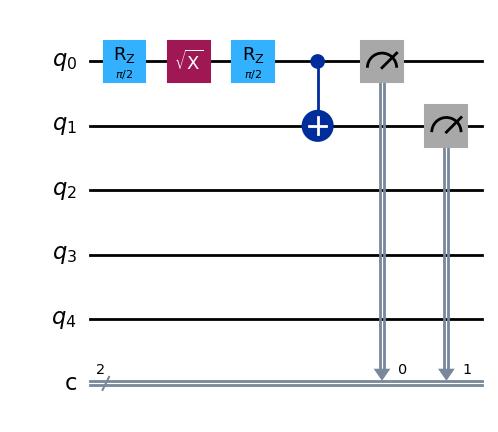

In [4]:
# Matplotlib drawing
circuit.draw(output="mpl")

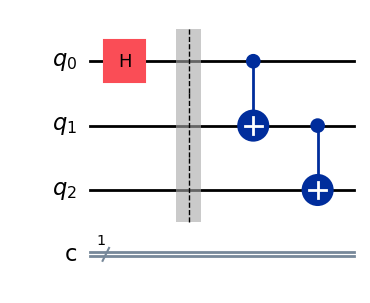

In [41]:
from qiskit import QuantumCircuit
import numpy as np

# Create a 3-qubit quantum circuit with 1 classical bit for measurement
circuit = QuantumCircuit(3, 1)

# Define alpha and beta as complex coefficients (can be set to any value, here we set alpha = beta = 1/sqrt(2))
alpha = 1 / np.sqrt(2)
beta = 1 / np.sqrt(2)

# Apply a Hadamard gate to the first qubit (equivalent to alpha|0> + beta|1>)
circuit.h(0)

# Add a barrier for visual separation
circuit.barrier()

# Convert the quantum circuit to a gate (U)
#U = circuit.to_gate()
#U.name = r'|\psi\rangle'  # Set the name as the LaTeX-style text for clarity

# Apply the CNOT gates
circuit.cx(0, 1)  # Control qubit 0, target qubit 1
circuit.cx(1, 2)  # Control qubit 1, target qubit 2

# Draw the circuit
circuit.draw(output='mpl', filename='three-qubit-encoding-circuit.pdf')  # Visualize and save as a PDF


In [20]:
print(circuit)

     ┌───┐ ░           
q_0: ┤ H ├─░───■───────
     └───┘ ░ ┌─┴─┐     
q_1: ──────░─┤ X ├──■──
           ░ └───┘┌─┴─┐
q_2: ──────░──────┤ X ├
           ░      └───┘


In [21]:
circuit.draw()

┌───┐ ░           
q_0: ┤ H ├─░───■───────
     └───┘ ░ ┌─┴─┐     
q_1: ──────░─┤ X ├──■──
           ░ └───┘┌─┴─┐
q_2: ──────░──────┤ X ├
           ░      └───┘

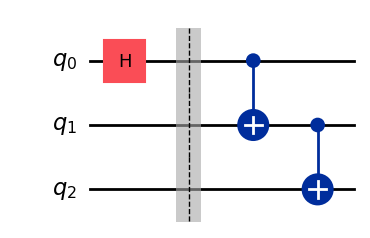

In [22]:
# Matplotlib drawing
circuit.draw(output="mpl")

In [26]:
psi = Statevector(circuit)

In [27]:
psi.draw("latex")  #

<IPython.core.display.Latex object>

In [28]:
from qiskit.quantum_info import DensityMatrix

DensityMatrix(psi).draw("latex")  # convert to a DensityMatrix and draw

<IPython.core.display.Latex object>

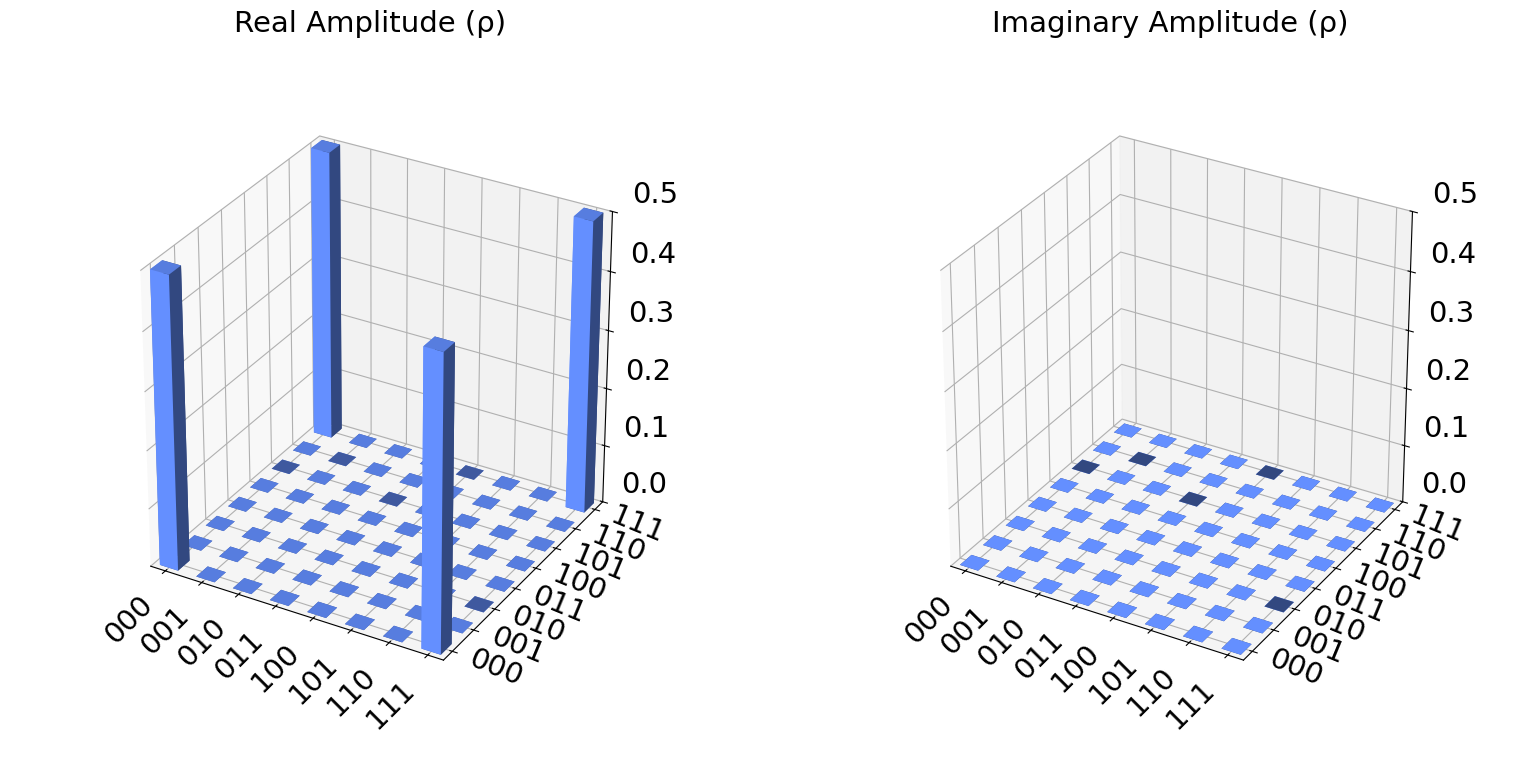

In [32]:
from qiskit.visualization import plot_state_city

plot_state_city(psi)
# Alternative: psi.draw("city")

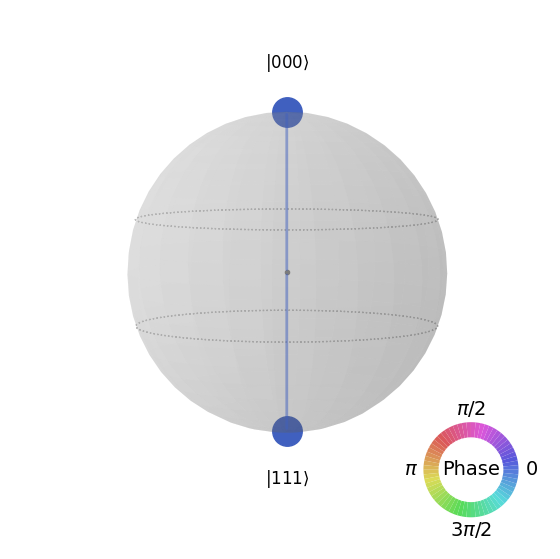

In [30]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)
#psi.draw("qsphere", filename='qsphere_plot.pdf')
#import matplotlib.pyplot as plt
#plt.savefig("qsphere_plot.png")

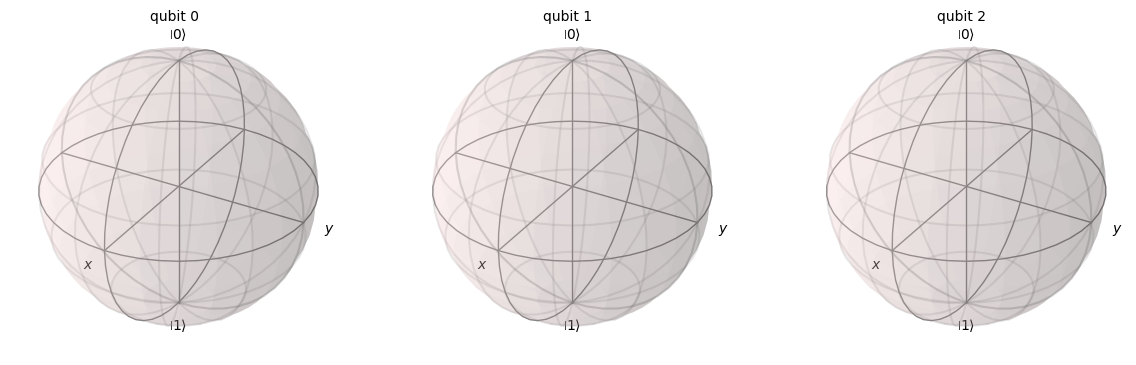

In [31]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)
# Alternative: psi.draw("bloch")

In [10]:
from qiskit import QuantumCircuit
import numpy as np

# Create a 3-qubit quantum circuit with 1 classical bit for measurement
circuit = QuantumCircuit(5, 1)

# Define alpha and beta as complex coefficients (can be set to any value, here we set alpha = beta = 1/sqrt(2))
alpha = 1 / np.sqrt(2)
beta = 1 / np.sqrt(2)

circuit.h(0)  # This is equivalent to (alpha|0> + beta|1>), assuming alpha=beta=1/sqrt(2)

# Apply the CNOT gates
circuit.cx(0, 1)  # Control qubit 0, target qubit 1
circuit.cx(1, 2)  # Control qubit 1, target qubit 2

circuit.cx(0, 3)
circuit.cx(1, 3)

circuit.cx(1, 4)
circuit.cx(2, 4)

circuit.measure(circuit[3], circuit[1]);
circuit.measure(circuit[4], circuit[1]);

# Draw the circuit (optional visualization)
circuit.draw()

CircuitError: "Invalid bit index: 'Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])' of type '<class '_SingletonCXGate'>'"

In [11]:
qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)


circuit.h(0)  # This is equivalent to (alpha|0> + beta|1>), assuming alpha=beta=1/sqrt(2)

# Apply the CNOT gates
circuit.cx(qreg_q[0], qreg_q[1])  # Control qubit 0, target qubit 1
circuit.cx(qreg_q[1], qreg_q[2])  # Control qubit 1, target qubit 2

circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[3])

circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[2], qreg_q[4])

circuit.measure(qreg_q[3],creg_c[0]);
circuit.measure(qreg_q[4],creg_c[1]);

#circuit.rz(1.5707963267948966, qreg_q[0])
#circuit.sx(qreg_q[0])
#circuit.rz(1.5707963267948966, qreg_q[0])
#circuit.cx(qreg_q[0], qreg_q[1])
#circuit.measure(qreg_q[0], creg_c[0])
#circuit.measure(qreg_q[1], creg_c[0])

In [64]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Create a quantum register of 5 qubits
qreg_q = QuantumRegister(5, 'q')

# Create an empty classical register for storing measurements (you can ignore it in the drawing)
creg_c = ClassicalRegister(2, 'c')  # Classical register with 2 bits to store measurements

# Create the quantum circuit
circuit = QuantumCircuit(qreg_q, creg_c)

# Apply a Hadamard gate to the first qubit
#circuit.h(qreg_q[0])

# Apply the CNOT gates
circuit.cx(qreg_q[0], qreg_q[1])  # Control qubit 0, target qubit 1
circuit.cx(qreg_q[1], qreg_q[2])  # Control qubit 1, target qubit 2
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.barrier(qreg_q[0],qreg_q[1], qreg_q[2])
circuit.barrier(qreg_q[0],qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[2], qreg_q[4])


#circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
#circuit.barrier(qreg_q[0],qreg_q[1], qreg_q[2])
#circuit.barrier(qreg_q[0],qreg_q[1], qreg_q[2])
circuit.barrier()
# Perform measurements on qubits 3 and 4, storing the results in classical bits 0 and 1
circuit.measure(qreg_q[3], creg_c[0])  # Measure qreg_q[3], store in creg_c[0]
circuit.measure(qreg_q[4], creg_c[1])  # Measure qreg_q[4], store in creg_c[1]
circuit.barrier(qreg_q[3], qreg_q[4])
circuit.barrier(qreg_q[3], qreg_q[4])
circuit.barrier()
circuit.x(qreg_q[0])
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])
# Display the circuit (it will now show classical register bits)
circuit.draw()


░  ░  ░                      ░              ░ ┌───┐
q_0: ──■────────░──░──░───■──────────────────░──────────────░─┤ X ├
     ┌─┴─┐      ░  ░  ░   │                  ░              ░ ├───┤
q_1: ┤ X ├──■───░──░──░───┼────■────■────────░──────────────░─┤ X ├
     └───┘┌─┴─┐ ░  ░  ░   │    │    │        ░              ░ ├───┤
q_2: ─────┤ X ├─░──░──░───┼────┼────┼────■───░──────────────░─┤ X ├
          └───┘ ░  ░  ░ ┌─┴─┐┌─┴─┐  │    │   ░ ┌─┐    ░  ░  ░ └───┘
q_3: ───────────────────┤ X ├┤ X ├──┼────┼───░─┤M├────░──░──░──────
                        └───┘└───┘┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐ ░  ░  ░      
q_4: ─────────────────────────────┤ X ├┤ X ├─░──╫─┤M├─░──░──░──────
                                  └───┘└───┘ ░  ║ └╥┘ ░  ░  ░      
c: 2/═══════════════════════════════════════════╩══╩═══════════════
                                                0  1

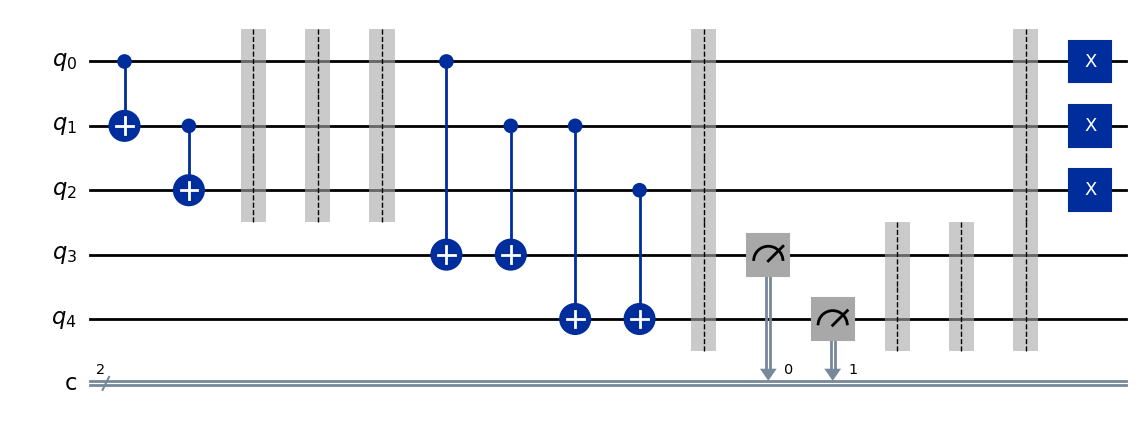

In [65]:
# Matplotlib drawing
circuit.draw(output="mpl", filename='full-circuit-error-detecting-3qubitcircuit.pdf')

In [48]:
psi = Statevector(circuit)

In [49]:
psi.draw("latex")  # psi is a Statevector object

<IPython.core.display.Latex object>

In [50]:
from qiskit.quantum_info import DensityMatrix

DensityMatrix(psi).draw("latex")  # convert to a DensityMatrix and draw

<IPython.core.display.Latex object>

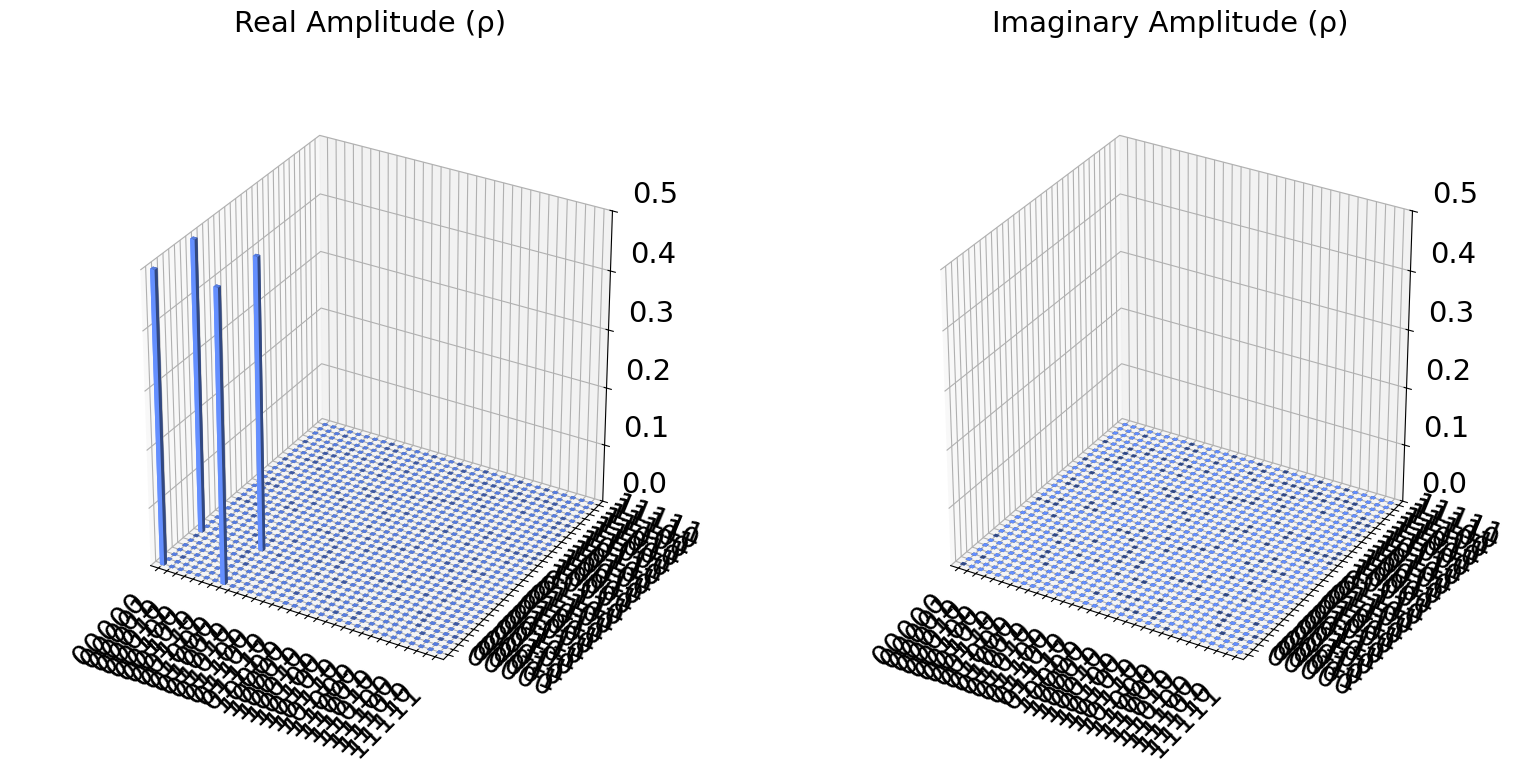

In [51]:
from qiskit.visualization import plot_state_city

plot_state_city(psi)
# Alternative: psi.draw("city")

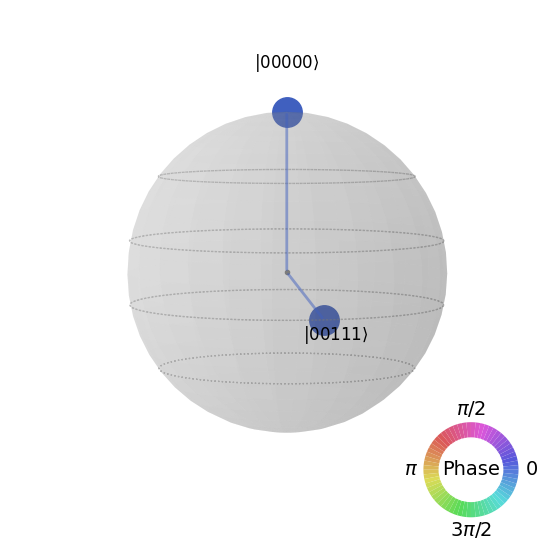

In [72]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)
#psi.draw("qsphere", filename='qsphere_plot.pdf')
#import matplotlib.pyplot as plt
#plt.savefig("qsphere_plot.png")

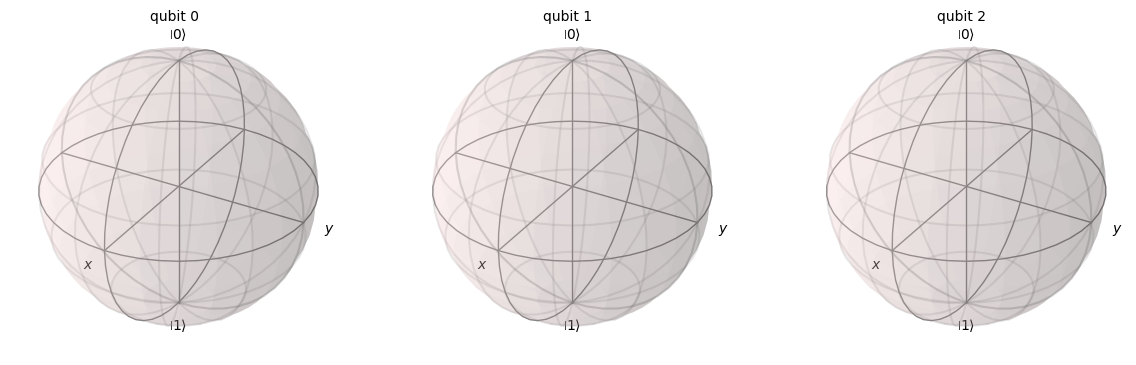

In [43]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)
# Alternative: psi.draw("bloch")

###IBM Code

In [23]:
from math import pi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Create a Bell state for demonstration
qc = QuantumCircuit(2)
qc.h(0)
qc.crx(pi / 2, 0, 1)
psi = Statevector(qc)

In [24]:
psi.draw("latex")  # psi is a Statevector object

<IPython.core.display.Latex object>

In [25]:
from qiskit.quantum_info import DensityMatrix

DensityMatrix(psi).draw("latex")  # convert to a DensityMatrix and draw

<IPython.core.display.Latex object>

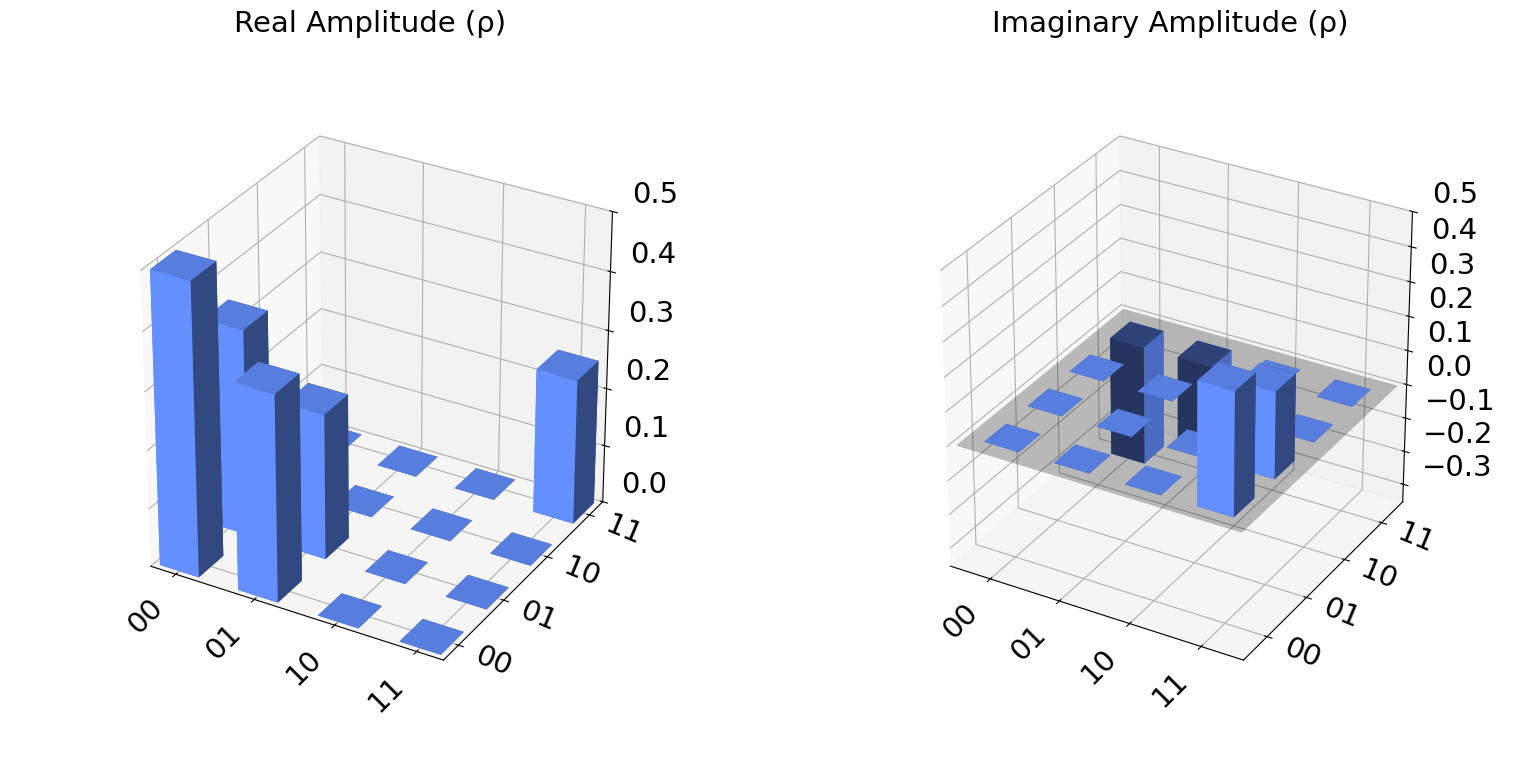

In [26]:
from qiskit.visualization import plot_state_city

plot_state_city(psi)
# Alternative: psi.draw("city")

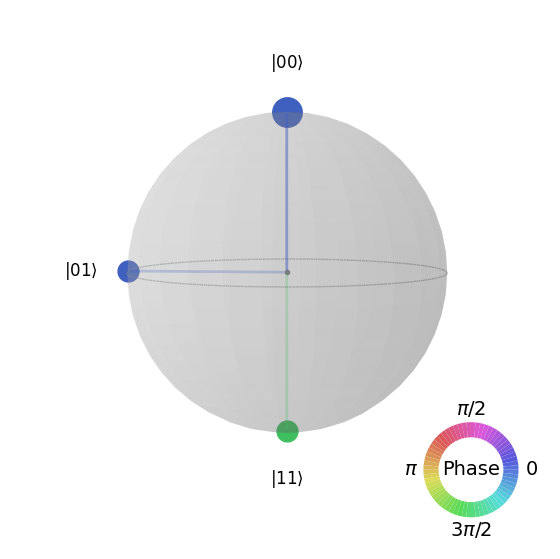

In [27]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)
# Alternative: psi.draw("qsphere")

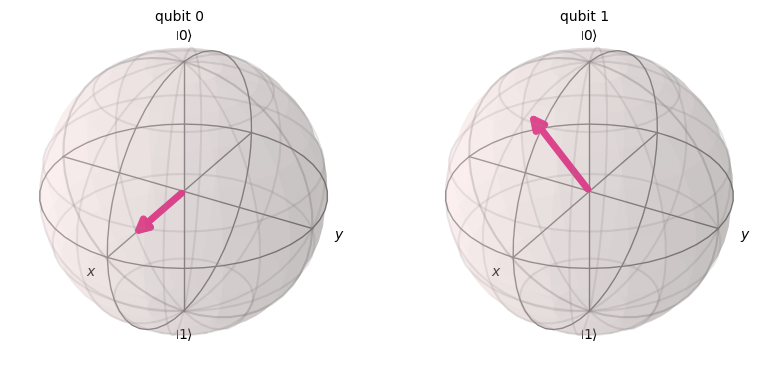

In [28]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)
# Alternative: psi.draw("bloch")

In [29]:
from qiskit_aer.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

sampler = Sampler(backend_options={"seed_simulator": 1234})

In [30]:
# quantum circuit to make a Bell state
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# execute the quantum circuit
quasi_dists = sampler.run(bell, shots=1000).result().quasi_dists[0]
print(quasi_dists)

{3: 0.485, 0: 0.515}


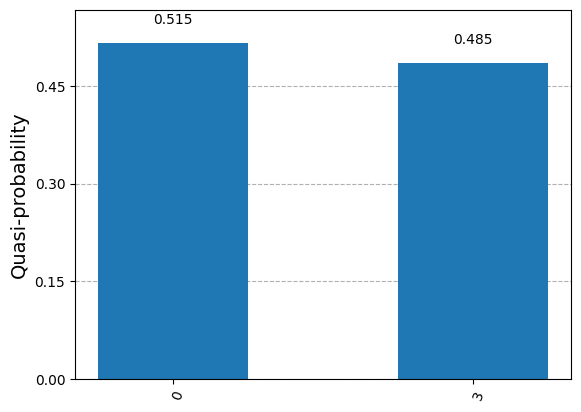

In [31]:
plot_histogram(quasi_dists)

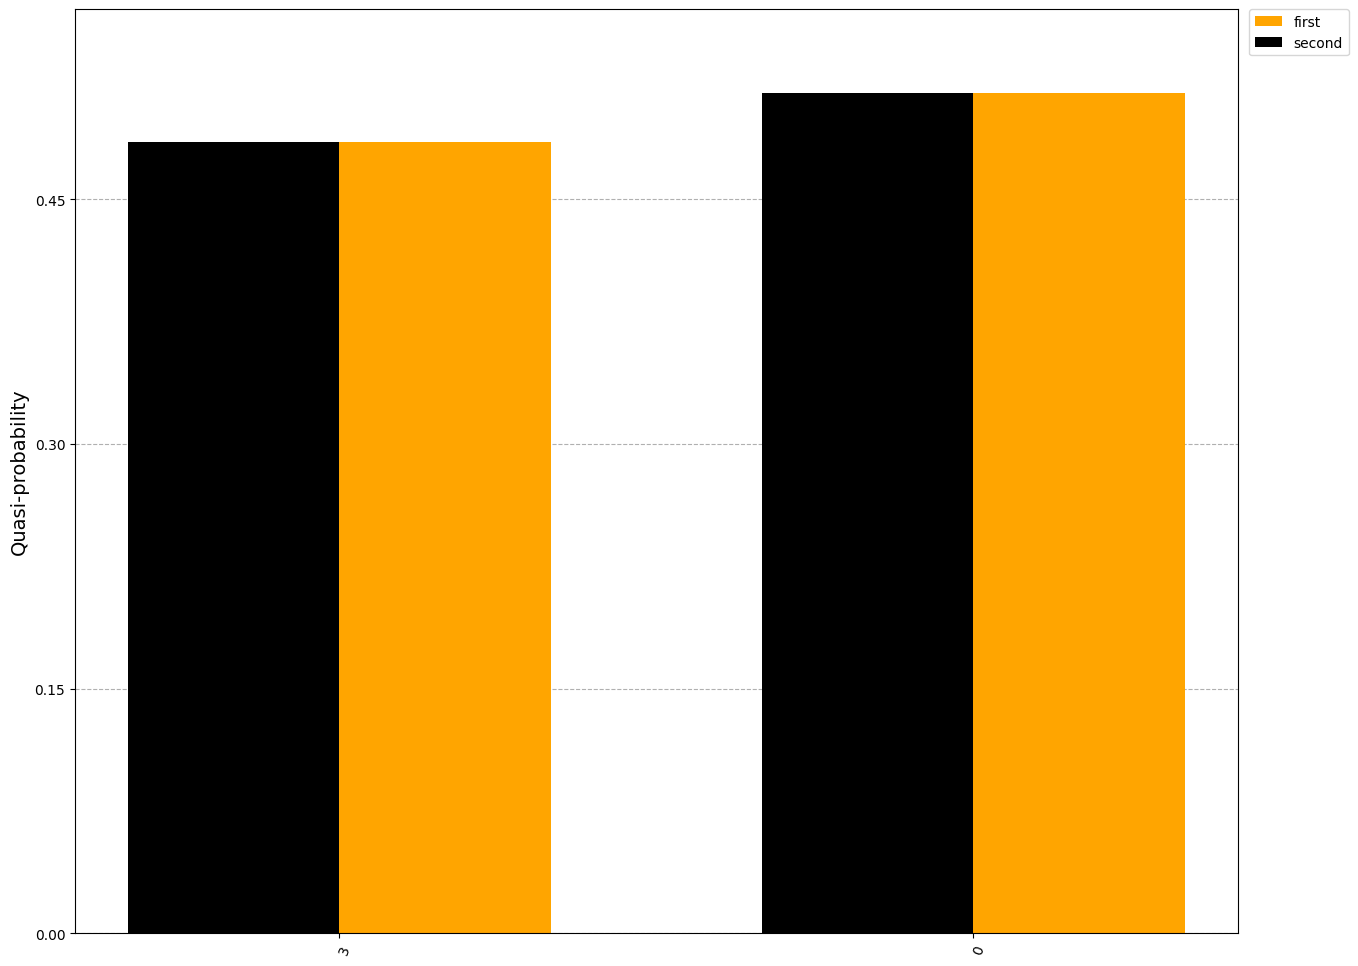

In [32]:
# Execute two-qubit Bell state again
second_quasi_dists = sampler.run(bell, shots=1000).result().quasi_dists[0]

# Plot results with custom options
plot_histogram(
    [quasi_dists, second_quasi_dists],
    legend=["first", "second"],
    sort="desc",
    figsize=(15, 12),
    color=["orange", "black"],
    bar_labels=False,
)

In [80]:
# Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, plot_state_city, plot_state_paulivec, plot_state_hinton

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Define backend
sim = Aer.get_backend('aer_simulator')

ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)

In [74]:
sim = Aer.get_backend('aer_simulator')

NameError: name 'Aer' is not defined

In [66]:
!pip install qtcodes

  Preparing metadata (setup.py) ... done
  Created wheel for qtcodes: filename=qtcodes-0.2.0-py3-none-any.whl size=37985 sha256=50c5b6f728c4990a12a371568f9b661e0c155c82764a6833ec6f506f30156831
  Stored in directory: /root/.cache/pip/wheels/0f/c2/8e/cff5897ddd36bb19e0150432931421307b1bd4a324b50920db
Successfully built qtcodes


In [68]:
import qtcodes as qtc

ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)

In [69]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates

    return noise_model

ModuleNotFoundError: No module named 'qiskit.providers.aer'

#Shor's Code in Qiskit

In [4]:
q = QuantumRegister(3,'q')

In [5]:
c = ClassicalRegister(1,'c')

In [6]:
circuit = QuantumCircuit(q,c)

In [7]:
circuit.cx(q[0],q[1])
circuit.cx(q[0],q[2])

In [8]:
circuit.x(q[0]) #Add this to simulate a bit flip error

In [11]:
circuit.draw()

┌───┐          ┌───┐
q_0: ──■────■──┤ X ├──■────■──┤ X ├
     ┌─┴─┐  │  └───┘┌─┴─┐  │  └─┬─┘
q_1: ┤ X ├──┼───────┤ X ├──┼────■──
     └───┘┌─┴─┐     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──────────┤ X ├──■──
          └───┘          └───┘     
c: 1/══════════════════════════════

In [9]:
circuit.cx(q[0],q[1])
circuit.cx(q[0],q[2])

In [10]:
circuit.ccx(q[2],q[1],q[0])

In [12]:
circuit.measure(q,c)

CircuitError: 'register size error'

In [13]:
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor

print('\nBit Flip Code')
print('----------------')

IBMQ.enable_account('ENTER API KEY HERE')
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')

q = QuantumRegister(3,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[1])
circuit.cx(q[0],q[2])
circuit.x(q[0]) #Add this to simulate a bit flip error
circuit.cx(q[0],q[1])
circuit.cx(q[0],q[2])
circuit.ccx(q[2],q[1],q[0])
circuit.measure(q[0],c[0])

job = execute(circuit, backend, shots=1000)

job_monitor(job)

counts = job.result().get_counts()

print("\nBit flip code with error")
print("----------------------")
print(counts)
input()

ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)

In [14]:
print('\nShor Code')
print('--------------')

from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor

IBMQ.enable_account(‘ENTER API KEY HERE')
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')

q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.h(q[0])

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.h(q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

job = execute(circuit, backend, shots=1000)

job_monitor(job)

counts = job.result().get_counts()

print("\n Uncorrected bit flip and phase error")
print("--------------------------------------")
print(counts)

#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw(output='mpl',filename='shorcode.png') #Draws an image of the circuit

job = execute(circuit, backend, shots=1000)

job_monitor(job)

counts = job.result().get_counts()

print("\nShor code with bit flip and phase error")
print("----------------------------------------")
print(counts)
input()

SyntaxError: invalid character '‘' (U+2018) (<ipython-input-14-76f68c3df5f6>, line 9)

#Toric Code on Quntum Computer

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.4 MB/s eta 0:00:00


# The Model

What is the source of all this fascinating physics? The Hamiltonian is:

$$\mathcal{H} = -\sum_s S_s - \sum_p P_p,$$

where

$$S_s = \prod_{i \in s} Z_i \quad P_p = \prod_{j \in p} X_j.$$

In the literature, the $S_s$ terms are called the "star" operators, and
the $P_p$ terms are called the "plaquette" operators. Each star $s$ and
plaquette $p$ is a group of 4 sites on a square lattice. You can compare
this model to something like the [Heisenberg
model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) used to
describe spins interacting magnetically in a material.

In the most common formulation of the model, sites live on the edges of
a square lattice. In this formulation, the "plaquette" operators are
products of Pauli X operators on all the sites in a square, and the
\"star\" operators are products of Pauli Z operators on all the sites
bordering a vertex.

Instead, we can view the model as a checkerboard of alternating square
types. In this formulation, all sites $i$ and $j$ are the vertices of a
square lattice. Each square is a group of four sites, and adjacent
squares alternate between the two types of groups. Since the groups on
this checkerboard no longer look like stars and plaquettes, we will call
them the "Z Group" and "X Group" operators in this tutorial.

<figure>
<img
src="https://github.com/quantumlib/ReCirq/blob/master/docs/_static/demonstration_assets/toric_code/stars_plaquettes2.png?raw=1"
class="align-center" style="width:70.0%"
alt="../_static/demonstration_assets/toric_code/stars_plaquettes2.png" />
<figcaption>On the left, sites are grouped into stars around vertices
and plaquettes on the faces. On the right, we view the lattice as a
checkerboard of alternating types of groups.</figcaption>
</figure>

We will be embedding the lattice on a torus via periodic boundary
conditions. Periodic boundary conditions basically "glue" the bottom of
the lattice to the top of the lattice and the left to the right.

Modular arithmetic accomplishes this matching. Any site at `(x,y)` is
the same as a site at `(x+width, y+height)`.

<figure>
<img
src="https://github.com/quantumlib/ReCirq/blob/master/docs/_static/demonstration_assets/toric_code/converting_to_torus.png?raw=1"
class="align-center" style="width:70.0%"
alt="../_static/demonstration_assets/toric_code/converting_to_torus.png" />
<figcaption>By matching up the edges with periodic boundary conditions,
we turn a square grid into a torus.</figcaption>
</figure>


On to some practical coding! First, let\'s define the sites on a
$4\times 6$ lattice.

In [3]:
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product
from dataclasses import dataclass

import numpy as np

np.set_printoptions(suppress=True)

height = 4
width = 6

all_sites = [(i, j) for i, j in product(range(width), range(height))]

We would like for our wire labels to match the sites. To do this, we
will be using an [Immutable Data
Class](https://realpython.com/python-data-classes/#immutable-data-classes)
. PennyLane allows wire labels to be any **hashable** object, but
iterable wire labels are currently not supported. Therefore we use a
frozen dataclass to represent individual wires by a row and column
position.

In [4]:
@dataclass(frozen=True)
class Wire:
    i: int
    j: int

example_wire = Wire(0, 0)
print("Example wire: ", example_wire)
print("At coordinates: ", example_wire.i, example_wire.j)

Example wire:  Wire(i=0, j=0)
At coordinates:  0 0


In [5]:
mod = lambda s: Wire(s[0] % width, s[1] % height)

zgroup_sites = []  # list of sites in each group
zgroup_ops = []  # list of operators for each group

for x, y in product(range(width // 2), range(height)):

    x0 = 2 * x + (y + 1) % 2 # x starting coordinate

    sites = [(x0, y), (x0 + 1, y), (x0 + 1, y + 1), (x0, y + 1)]

    op = qml.prod(*(qml.PauliZ(mod(s)) for s in sites))

    zgroup_sites.append(sites)
    zgroup_ops.append(op)

print("First set of sites: ", zgroup_sites[0])
print("First operator: ", zgroup_ops[0])

First set of sites:  [(1, 0), (2, 0), (2, 1), (1, 1)]
First operator:  Z(Wire(i=1, j=0)) @ Z(Wire(i=2, j=0)) @ Z(Wire(i=2, j=1)) @ Z(Wire(i=1, j=1))


In [6]:
xgroup_sites = []
xgroup_ops = []
for x, y in product(range(width // 2), range(height)):
    x0 = 2 * x + y % 2 # lower x coordinate

    sites = [(x0 + 1, y + 1), (x0, y + 1), (x0, y), (x0 + 1, y)]

    if x == 2 and y == 1:  # change order for state prep later
        sites = sites[1:] + sites[0:1]

    op = qml.prod(*(qml.PauliX(mod(s)) for s in sites))

    xgroup_sites.append(sites)
    xgroup_ops.append(op)

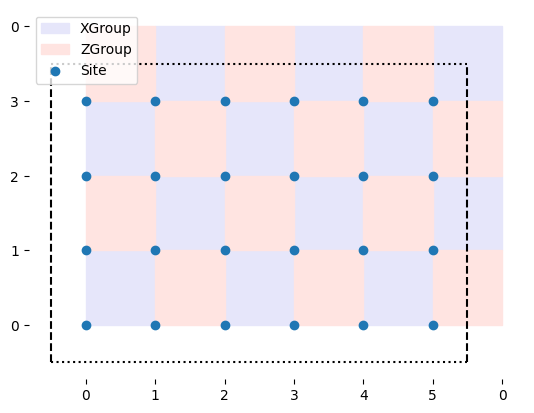

In [7]:
def misc_plot_formatting(fig, ax):
    plt.hlines([-0.5, height - 0.5], -0.5, width - 0.5, linestyle="dotted", color="black")
    plt.vlines([-0.5, width - 0.5], -0.5, height - 0.5, linestyle="dashed", color="black")
    plt.xticks(range(width + 1), [str(i % width) for i in range(width + 1)])
    plt.yticks(range(height + 1), [str(i % height) for i in range(height + 1)])

    for direction in ["top", "right", "bottom", "left"]:
        ax.spines[direction].set_visible(False)

    return fig, ax


fig, ax = plt.subplots()
fig, ax = misc_plot_formatting(fig, ax)

for group in xgroup_sites:
    x_patch = ax.add_patch(Polygon(group, color="lavender", zorder=0))

for group in zgroup_sites:
    z_patch = ax.add_patch(Polygon(group, color="mistyrose", zorder=0))

plt_sites = ax.scatter(*zip(*all_sites))

plt.legend([x_patch, z_patch, plt_sites], ["XGroup", "ZGroup", "Site"], loc="upper left")

plt.show()

In [8]:
dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites])

def state_prep():
    for op in xgroup_ops[0:-1]:
        qml.Hadamard(op.wires[0])
        for w in op.wires[1:]:
            qml.CNOT(wires=[op.wires[0], w])

@qml.qnode(dev, diff_method=None)
def circuit():
    state_prep()
    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

In [9]:
n_xgroups = len(xgroup_ops)
separate_expvals = lambda expvals: (expvals[:n_xgroups], expvals[n_xgroups:])

xgroup_expvals, zgroup_expvals = separate_expvals(circuit())

E0 = -sum(xgroup_expvals) - sum(zgroup_expvals)

print("X Group expectation values", [np.round(val) for val in xgroup_expvals])
print("Z Group expectation values", [np.round(val) for val in zgroup_expvals])
print("Total energy: ", E0)

X Group expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Z Group expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total energy:  -23.999999999999996


In [10]:
@qml.qnode(dev, diff_method=None)
def excitations(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

In [11]:
single_x = [(1, 2)]

x_expvals, z_expvals = separate_expvals(excitations(single_x, []))

print("XGroup: ", [np.round(val) for val in x_expvals])
print("ZGroup: ", [np.round(val) for val in z_expvals])

XGroup:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ZGroup:  [1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [12]:
occupation_numbers = lambda expvals: [0.5 * (1 - np.round(val)) for val in expvals]

def print_info(x_expvals, z_expvals):
    E = -sum(x_expvals) - sum(z_expvals)

    print("Total energy: ", E)
    print("Energy above the ground state: ", E - E0)
    print("X Group occupation numbers: ", occupation_numbers(x_expvals))
    print("Z Group occupation numbers: ", occupation_numbers(z_expvals))

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
def excitation_plot(x_excite, z_excite):
    x_color = lambda expval: "navy" if expval < 0 else "lavender"
    z_color = lambda expval: "maroon" if expval < 0 else "mistyrose"

    fig, ax = plt.subplots()
    fig, ax = misc_plot_formatting(fig, ax)

    for expval, sites in zip(x_excite, xgroup_sites):
        ax.add_patch(Polygon(sites, color=x_color(expval), zorder=0))

    for expval, sites in zip(z_excite, zgroup_sites):
        ax.add_patch(Polygon(sites, color=z_color(expval), zorder=0))

    handles = [
        Patch(color="navy", label="X Group -1"),
        Patch(color="lavender", label="X Group +1"),
        Patch(color="maroon", label="Z Group -1"),
        Patch(color="mistyrose", label="Z Group +1"),
        Patch(color="navy", label="Z op"),
        Patch(color="maroon", label="X op"),
    ]

    plt.legend(handles=handles, ncol=3, loc="lower left")

    return fig, ax

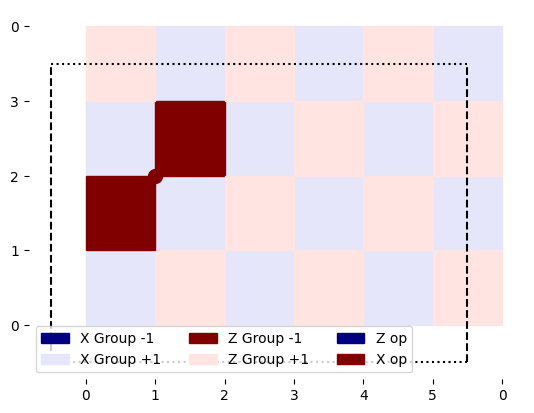

In [14]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_x), color="maroon", s=100)
plt.show()

In [15]:
single_z = [(1, 2)]

expvals = excitations([], single_z)
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


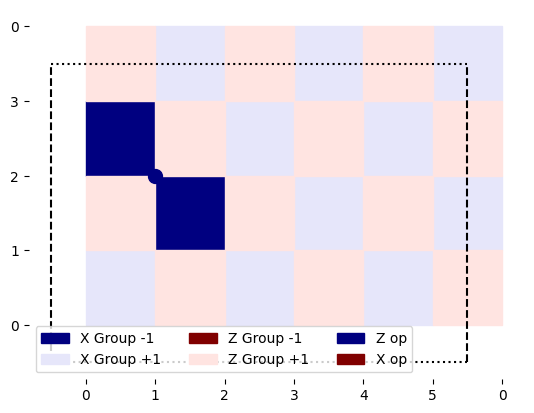

In [16]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_z), color="navy", s=100)
plt.show()

In [17]:
single_z = [(1, 2)]

expvals = excitations([], single_z + single_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
two_z = [(1, 2), (2, 2)]

expvals = excitations([], two_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


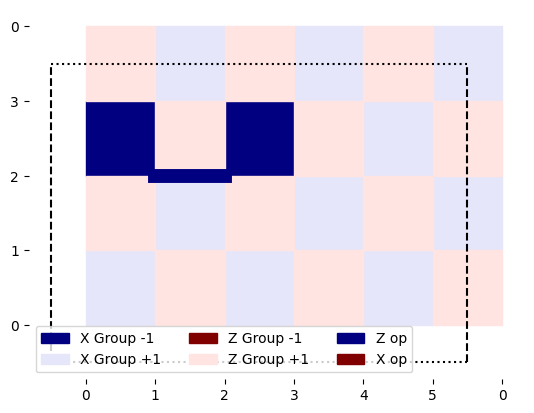

In [19]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*two_z), color="navy", linewidth=10)
plt.show()

In [20]:
long_string = [(1, 2), (2, 2), (3, 2), (4, 1)]

expvals = excitations([], long_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


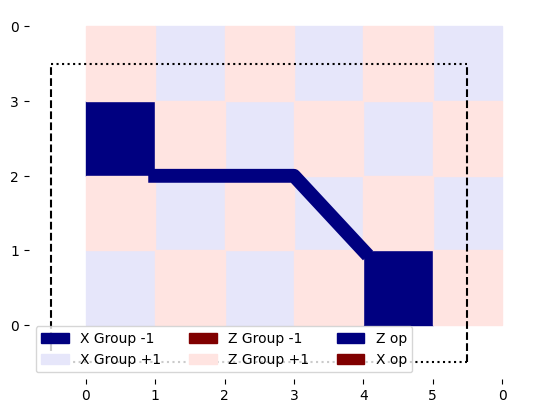

In [21]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*long_string), color="navy", linewidth=10)
plt.show()

In [22]:
equivalent_string = [(1, 2), (2, 1), (3, 1), (4, 1)]

expvals = excitations([], equivalent_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


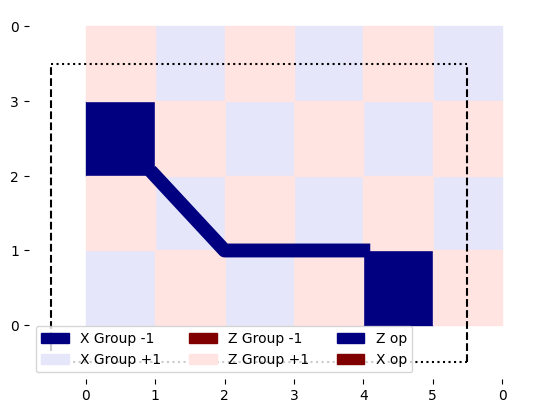

In [23]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*equivalent_string), color="navy", linewidth=10)
plt.show()

In [24]:
contractible_loop = [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (3, 3), (2, 3), (1, 2)]

expvals = excitations(contractible_loop, [])
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


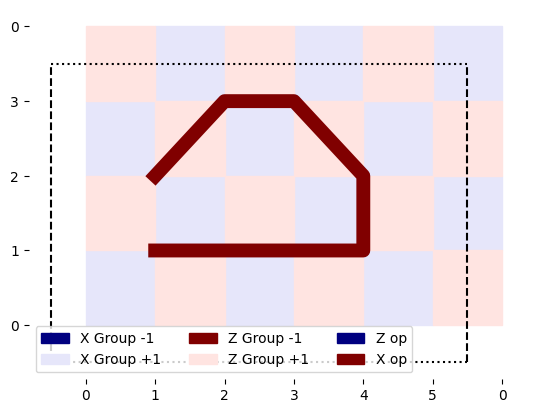

In [25]:
fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*contractible_loop), color="maroon", linewidth=10)

plt.show()

In [26]:
@qml.qnode(dev, diff_method=None)
def probs(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return qml.probs(wires=[Wire(*s) for s in all_sites])


null_probs = probs([], [])
contractible_probs = probs(contractible_loop, [])

print("Are the probabilities equal? ", np.allclose(null_probs, contractible_probs))

Are the probabilities equal?  True


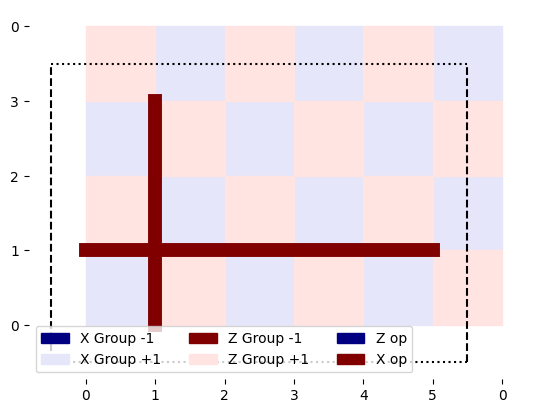

In [27]:
horizontal_loop = [(i, 1) for i in range(width)]
vertical_loop = [(1, i) for i in range(height)]

expvals = excitations(horizontal_loop + vertical_loop, [])
fig, ax = excitation_plot(*separate_expvals(expvals))

ax.plot(*zip(*horizontal_loop), color="maroon", linewidth=10)
ax.plot(*zip(*vertical_loop), color="maroon", linewidth=10)

plt.show()

In [28]:
null_probs = probs([], [])
horizontal_probs = probs(horizontal_loop, [])
vertical_probs = probs(vertical_loop, [])
combo_probs = probs(horizontal_loop + vertical_loop, [])

In [29]:
print("Are the probabilities equal? ", qml.math.allclose(null_probs, horizontal_probs))
print("Is this significant?")
print("Maximum difference in probabilities: ", max(abs(null_probs - horizontal_probs)))
print("Maximum probability: ", max(null_probs))

Are the probabilities equal?  False
Is this significant?
Maximum difference in probabilities:  0.00048828124999999913
Maximum probability:  0.00048828124999999913


In [30]:
probs_type_labels = ["null", "x", "y", "combo"]
all_probs = [null_probs, horizontal_probs, vertical_probs, combo_probs]

print("\t" + "\t".join(probs_type_labels))

for name, probs1 in zip(probs_type_labels, all_probs):
    comparisons = (str(np.allclose(probs1, probs2)) for probs2 in all_probs)
    print(name, "\t", "\t".join(comparisons))

	null	x	y	combo
null 	 True	False	False	False
x 	 False	True	False	False
y 	 False	False	True	False
combo 	 False	False	False	True


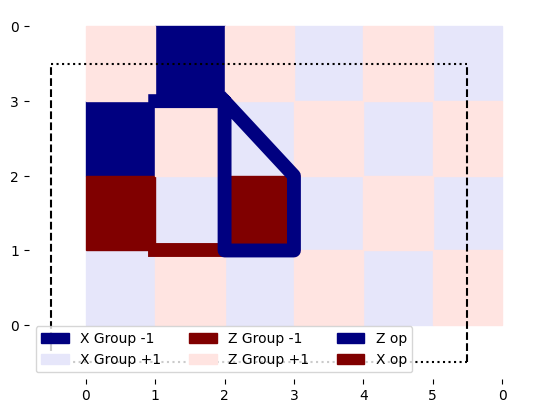

In [31]:
prep1 = [(1, 1), (2, 1)]
prep2 = [(1, 3)]
loop1 = [(2, 3), (2, 2), (2, 1), (3, 1), (3, 2), (2, 3)]

expvals = excitations(prep1, prep2 + loop1)
x_expvals, z_expvals = separate_expvals(expvals)

fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*prep1), color="maroon", linewidth=10)
ax.plot(*zip(*(prep2 + loop1)), color="navy", linewidth=10)

plt.show()

In [32]:
dev_aux = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites] + ["aux"])

def loop(x_loop, z_loop):
    for s in x_loop:
        qml.PauliX(Wire(*s))
    for s in z_loop:
        qml.PauliZ(Wire(*s))

@qml.qnode(dev_aux, diff_method=None)
def hadamard_test(x_prep, z_prep, x_loop, z_loop):
    state_prep()

    for s in x_prep:
        qml.PauliX(Wire(*s))

    for s in z_prep:
        qml.PauliZ(Wire(*s))

    qml.Hadamard("aux")
    qml.ctrl(loop, control="aux")(x_loop, z_loop)
    qml.Hadamard("aux")
    return qml.expval(qml.PauliZ("aux"))

x_around_z = hadamard_test(prep1, prep2, [], loop1)
print("Move x excitation around z excitation: ", x_around_z)

Move x excitation around z excitation:  -0.9999999999999991
